# Analysis of monoclonal antibody selection of mutant virus libraries of A/WSN/1933(H1N1) hemagglutinin
Mike Doud, 2016

## import modules and define variables

In [3]:
import os
import glob
import subprocess
import time
import pandas as pd
import numpy as np
import matplotlib
print "Using matplotlib version %s" % matplotlib.__version__
matplotlib.use("Pdf")
from matplotlib.ticker import MaxNLocator
import pylab as plt
from colour import Color
from IPython.display import Image, display

def ShowPDF(pdfs, width=None):
    '''Displays images in *pdfs*, which can be one PDF or list of PDFs. Multiple images displayed side-by-side.'''
    png = '_temp.png'
    if not isinstance(pdfs, list):
        pdfs = [pdfs]
    subprocess.check_call(['convert', '-density', '134', '-trim'] + pdfs + ['+append', png])
    time.sleep(0.5)
    display(Image(png, width=width))

# make directories for the analysis
dirs = {'fastq':'./FASTQ_files',
        'counts':'./counts_and_alignments/',
        'diffsel':'./differential_selections/',
        'plots':'./plots'}
for xdir in dirs.values():
    if not os.path.isdir(xdir):
        os.mkdir(xdir)

refseq = 'WSN_HA_reference.fa' # WSN HA nucleotide sequence used in these experiments
errorcontrolcounts = 'err_counts.txt' # counts for wildtype DNA from Doud and Bloom, 2016, Viruses
alignspecs = '1,285,36,37 286,570,31,32 571,855,37,32 856,1140,31,36 1141,1425,29,33 1426,1698,40,43' # see docs for `dms_barcodedsubamplicons`

Using matplotlib version 1.5.1


## define experimental samples and download sequencing data from the SRA
this downloads the `.SRA` file for each sample and then uses `fastq-dump` to extract `FASTQ` files for read 1 and read 2.

In [5]:
# sample names are structured as `LX_mAb_cX_rX` where LX denotes the mutant virus *L*ibrary used, mAb indicates the antibody used, 
# and cX and rX indicate different antibody concentrations or technical replicates when they exist. `mock` is no-antibody control.
SRA_samples = {
    'SRR4841569':'L1_H17L19_c1_r1',
    'SRR4841570':'L1_H17L19_c2_r1',
    'SRR4841567':'L1_H17L19_c3_r1',
    'SRR4841568':'L1_H17L19_c1_r2',
    'SRR4841573':'L1_H17L19_c2_r2',
    'SRR4841574':'L1_H17L19_c3_r2',
    'SRR4841571':'L2_H17L19_c1',
    'SRR4841572':'L2_H17L19_c2',
    'SRR4841575':'L2_H17L19_c3',
    'SRR4841576':'L3_H17L19_c1',
    'SRR4841595':'L3_H17L19_c2',
    'SRR4841596':'L3_H17L19_c3',
    'SRR4841597':'L1_H17L10',
    'SRR4841598':'L2_H17L10',
    'SRR4841599':'L3_H17L10',
    'SRR4841600':'L1_H17L7',
    'SRR4841601':'L2_H17L7',
    'SRR4841602':'L3_H17L7',
    'SRR4841603':'L1_H18S415',
    'SRR4841604':'L2_H18S415',
    'SRR4841579':'L3_H18S415',
    'SRR4841578':'L1_mock_r1',
    'SRR4841581':'L1_mock_r2',
    'SRR4841580':'L2_mock',
    'SRR4841582':'L3_mock'}

# A list of experimental sample names, which will be used to iterate over samples throughout the analysis:
samples = SRA_samples.values()

# download sequencing data if it doesn't already exist:
for (accession, samplename) in SRA_samples.items():
    if (os.path.isfile('{0}/{1}_1.fastq'.format(dirs['fastq'], samplename)) and os.path.isfile('{0}/{1}_2.fastq'.format(dirs['fastq'], samplename))):
        print "The FASTQ files for sample {0}, which corresponds to accession {1}, already exist.".format(samplename, accession)
    else:
        print "Downloading and converting file format for sample {0}, which corresponds to accession {1}.".format(samplename, accession)
        !cd FASTQ_files; wget --no-clobber 'ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR484/'$accession'/'$accession'.sra'
        !mv "FASTQ_files/"$accession".sra" "FASTQ_files/"$samplename".sra"
        !fastq-dump -O FASTQ_files/ --split-files "FASTQ_files/"$samplename".sra"

The FASTQ files for sample L1_H17L19_c2_r2, which corresponds to accession SRR4841573, already exist.
The FASTQ files for sample L1_mock_r1, which corresponds to accession SRR4841578, already exist.
The FASTQ files for sample L3_H18S415, which corresponds to accession SRR4841579, already exist.
The FASTQ files for sample L3_H17L19_c3, which corresponds to accession SRR4841596, already exist.
The FASTQ files for sample L1_H17L10, which corresponds to accession SRR4841597, already exist.
The FASTQ files for sample L3_H17L19_c2, which corresponds to accession SRR4841595, already exist.
The FASTQ files for sample L1_H17L19_c2_r1, which corresponds to accession SRR4841570, already exist.
The FASTQ files for sample L2_H17L19_c1, which corresponds to accession SRR4841571, already exist.
The FASTQ files for sample L2_H17L10, which corresponds to accession SRR4841598, already exist.
The FASTQ files for sample L3_H17L10, which corresponds to accession SRR4841599, already exist.
The FASTQ files f

## compute mutation counts from FASTQ files for each experimental sample

See documentation for [`dms_barcodedsubamplicons`](http://jbloomlab.github.io/dms_tools/dms_barcodedsubamplicons.html) for details on the algorithm for parsing mutation counts from FASTQ files.

In [6]:
for sample in samples:
    r1files = ['{0}/{1}_1.fastq'.format(dirs['fastq'], sample)]
    r2files = ['{0}/{1}_2.fastq'.format(dirs['fastq'], sample)]
    outprefix = '{0}/{1}_'.format(dirs['counts'], sample)
    
    subprocess.check_call(['dms_barcodedsubamplicons',
                           outprefix,
                           refseq,
                           ','.join(r1files),
                           ','.join(r2files)] + 
                           alignspecs.split() + [
                           '--R1trimlength', '200',
                           '--R2trimlength', '170',
                          ])

Show some summary statistics for alignments. Break into groups of alignments based on mAb for clarity.

here is the summary of the alignments for lib1_H17L19


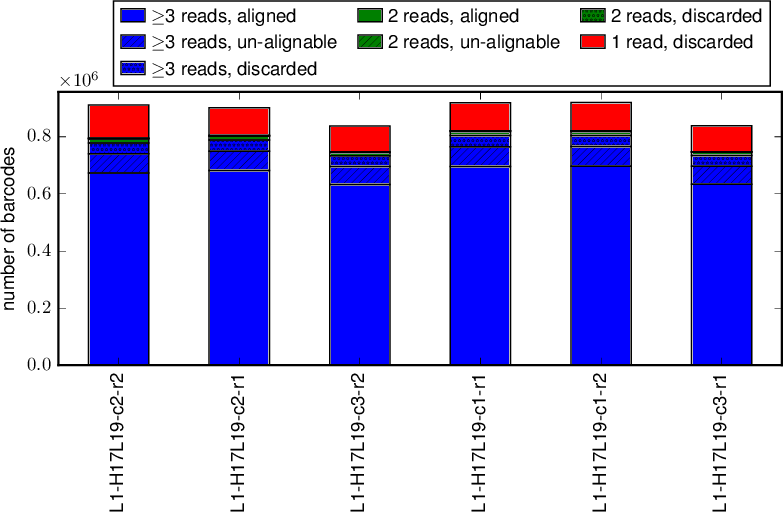

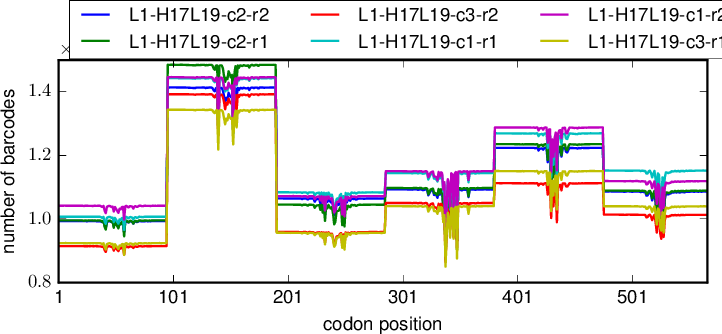

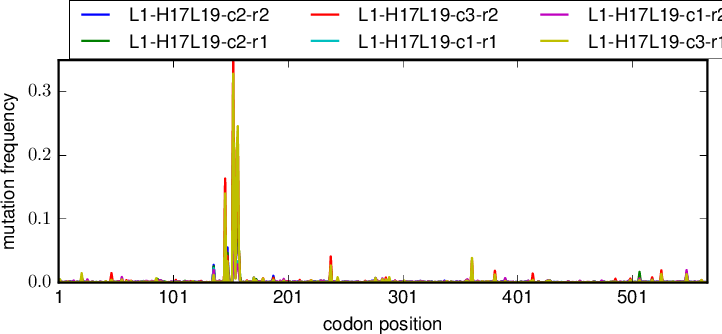

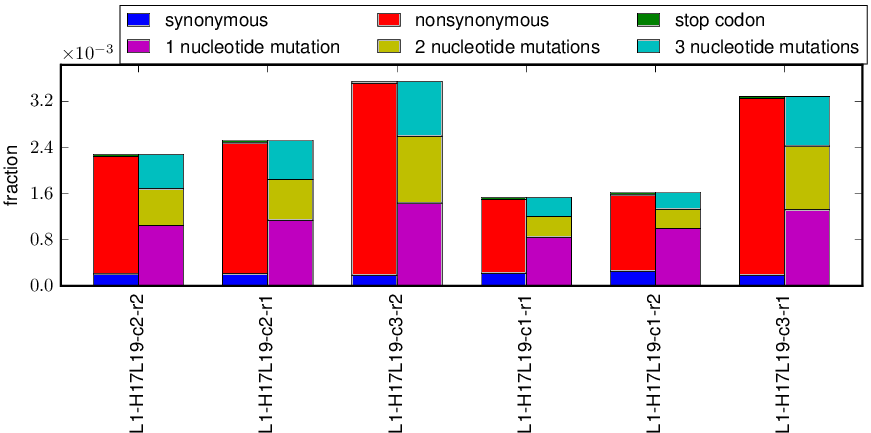

here is the summary of the alignments for lib23_H17L19


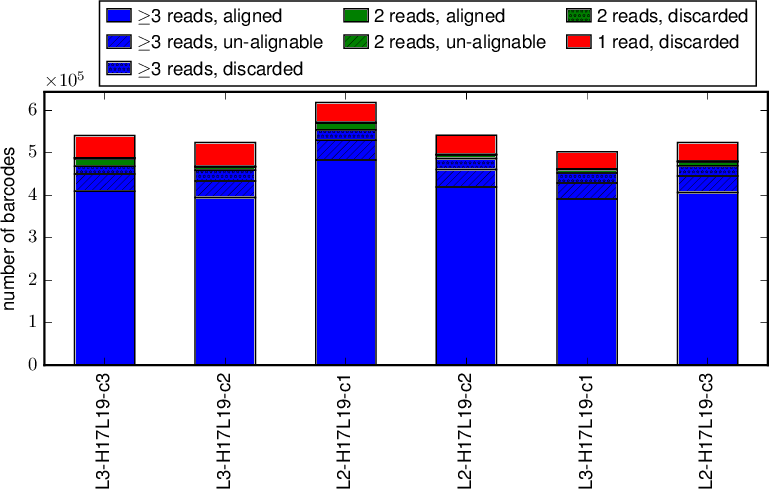

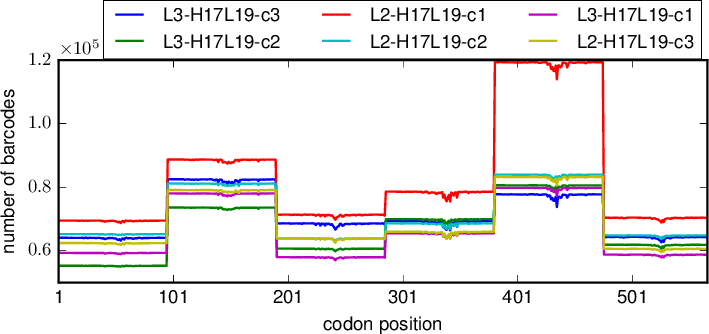

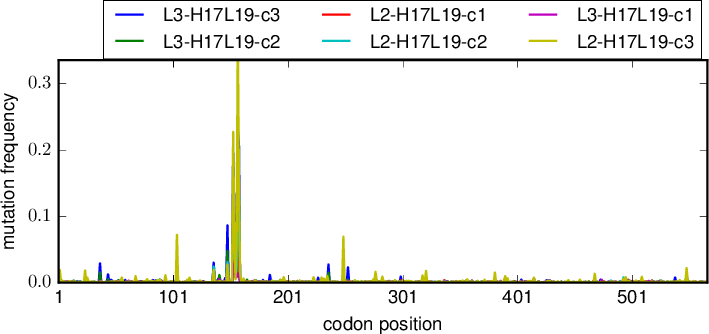

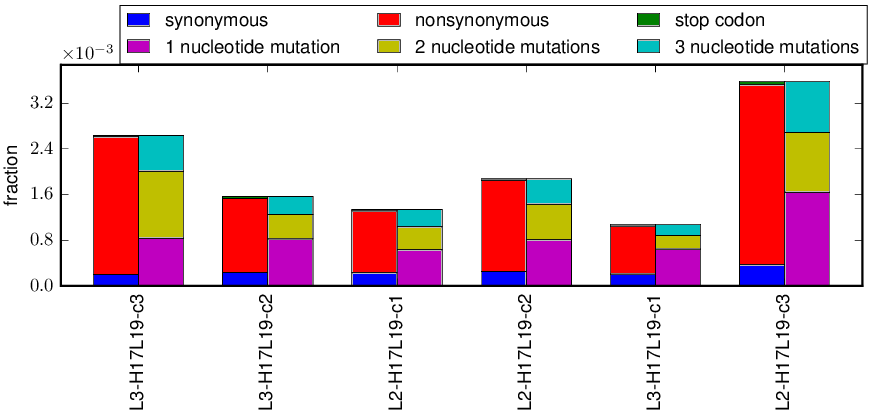

here is the summary of the alignments for H17L7


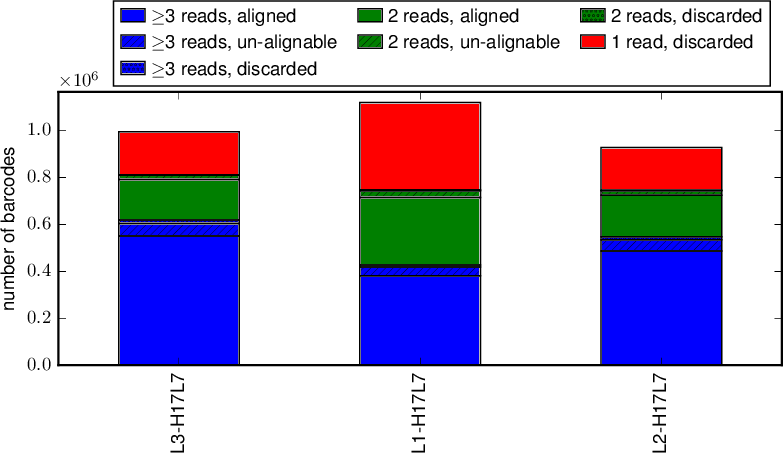

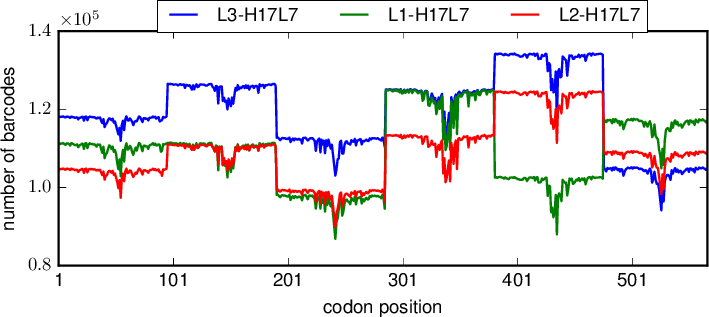

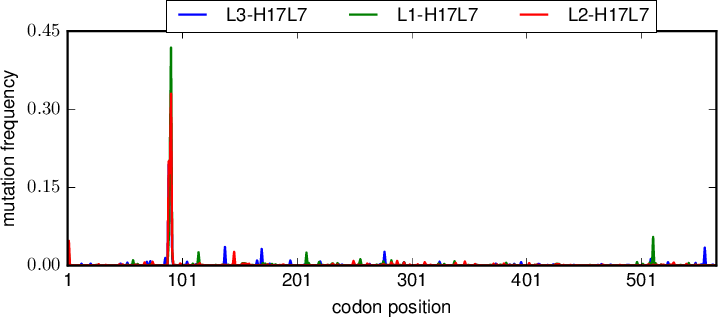

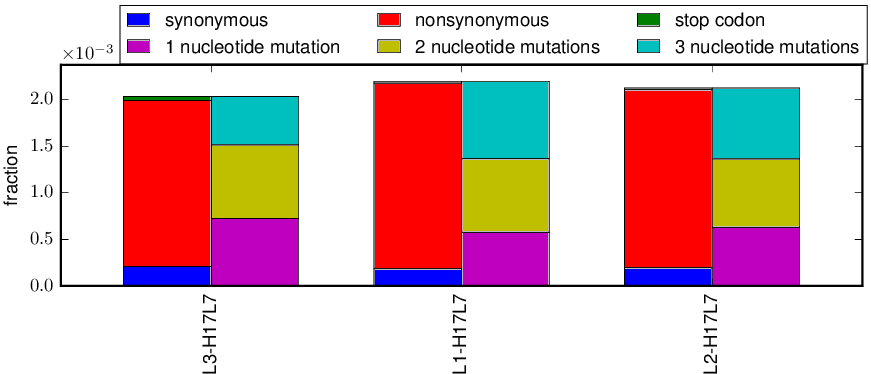

here is the summary of the alignments for H17L10


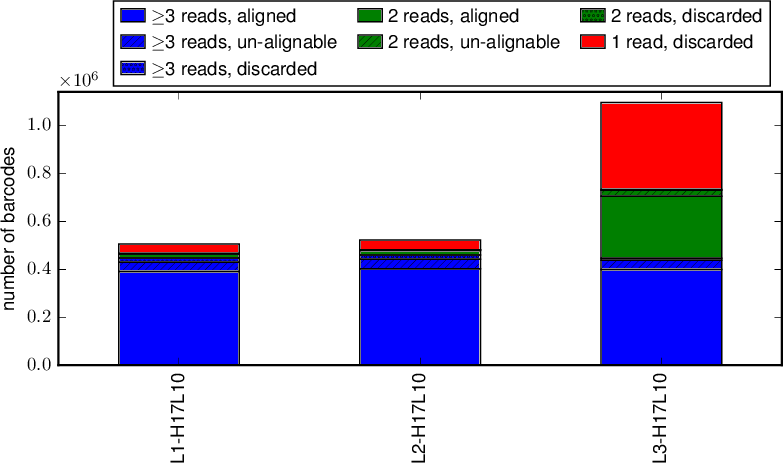

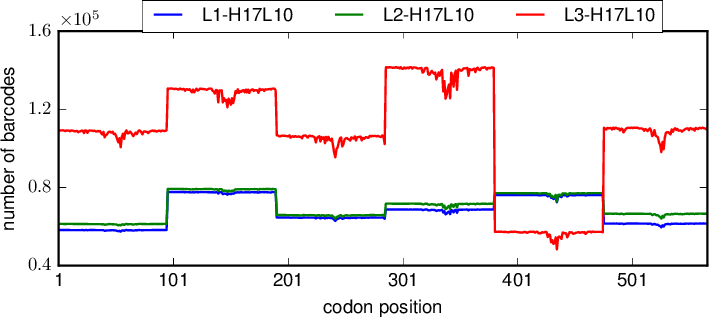

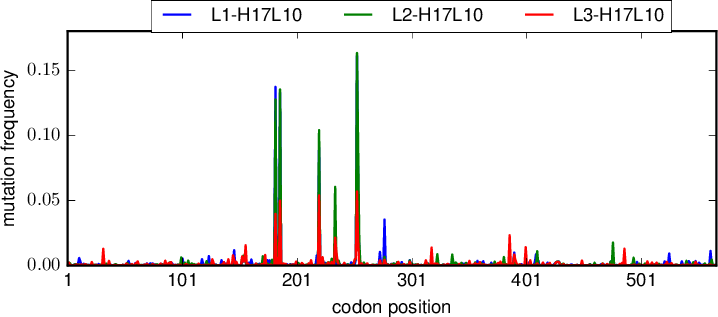

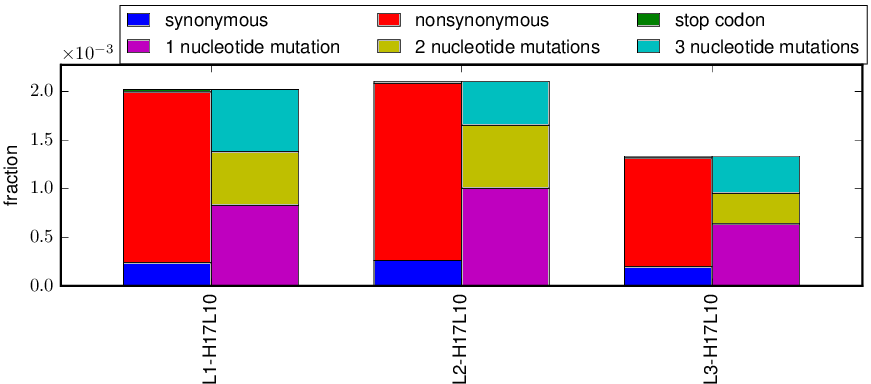

here is the summary of the alignments for H18S415


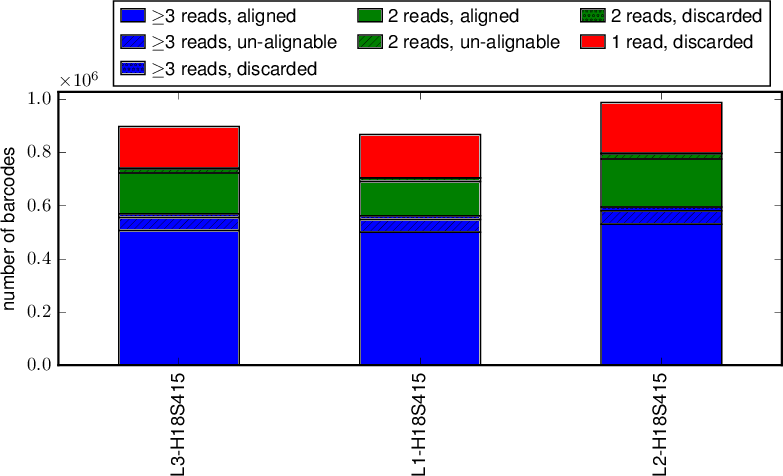

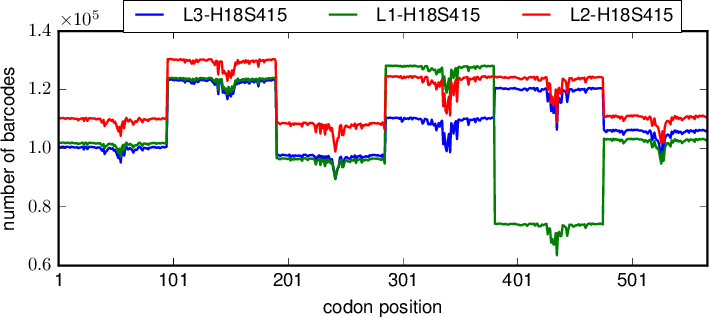

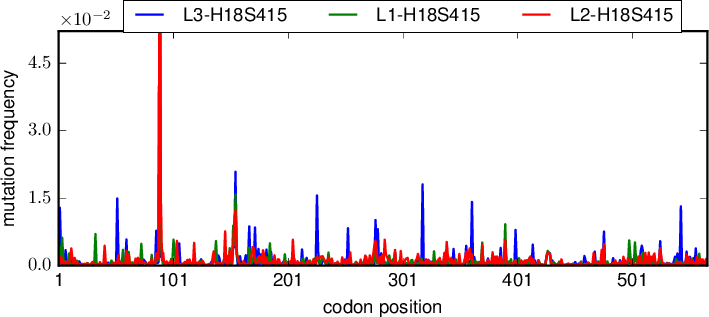

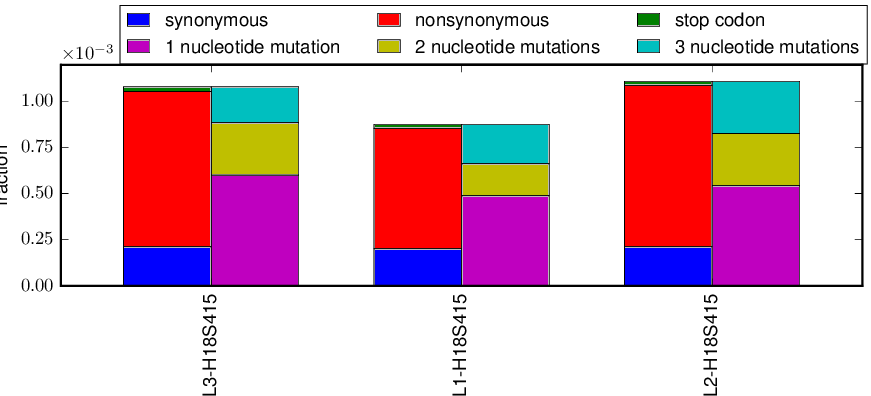

here is the summary of the alignments for mock


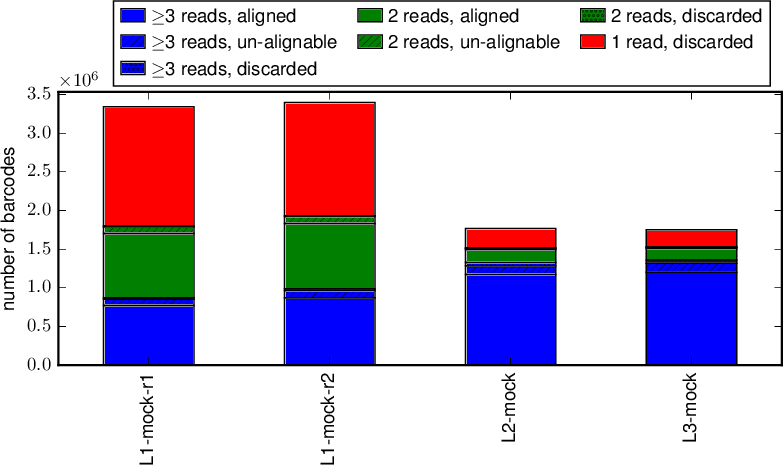

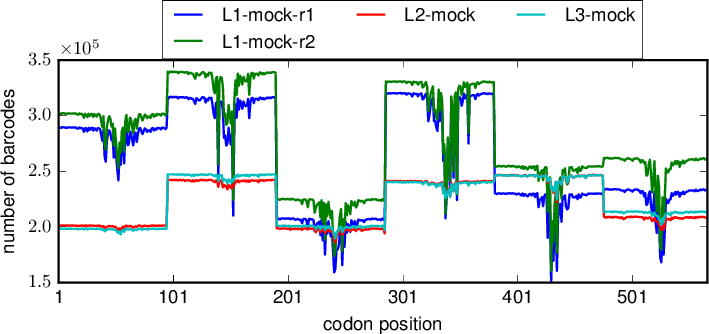

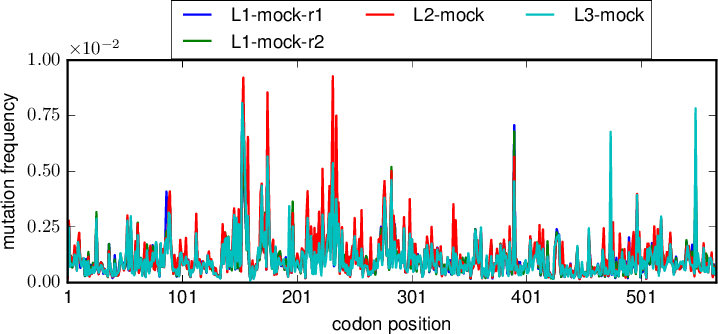

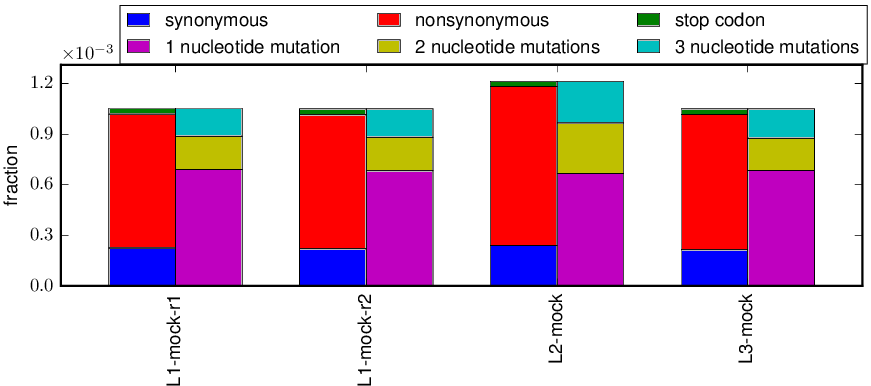

In [7]:
lib1_H17L19_samples = [s for s in samples if 'L1_H17L19' in s]
lib23_H17L19_samples = [s for s in samples if 'L2_H17L19' in s or 'L3_H17L19' in s]
H17L7_samples = [s for s in samples if 'H17L7' in s]
H17L10_samples = [s for s in samples if 'H17L10' in s]
H18S415_samples = [s for s in samples if 'H18S415' in s]
mock_samples = [s for s in samples if 'mock' in s] 

for sample_group, group_prefix in zip(
    [lib1_H17L19_samples, lib23_H17L19_samples, H17L7_samples, H17L10_samples, H18S415_samples, mock_samples],
    ['lib1_H17L19_', 'lib23_H17L19_', 'H17L7_', 'H17L10_', 'H18S415_', 'mock_']):
    
    print "here is the summary of the alignments for {0}".format(group_prefix[:-1])
    summary_list = []
    summary_prefix = '{0}/{1}'.format(dirs['counts'], group_prefix)
    for sample in sample_group:
        sample_outprefix = '{0}/{1}_'.format(dirs['counts'], sample) # the outprefix used for this sample by dms_barcodedsubamplicons
        summary_list.append(sample_outprefix + ',' + sample.replace('_','-')) # be sure to replace any underscores in the name of the alignment since they are processed by LaTeX.
    subprocess.check_call(['dms_summarizealignments',
                           summary_prefix,
                           'barcodedsubamplicons'] + 
                           summary_list
                          )
    
    for suffix in ['barcodes.pdf', 'depth.pdf', 'mutdepth.pdf', 'mutfreqs.pdf']:
        ShowPDF(summary_prefix + suffix, width=500)

## compute differential selection

see documentation for [`dms_diffselection`](http://jbloomlab.github.io/dms_tools/dms_diffselection.html) for details on the algorithm to compute differential selection between antibody-neutralized and no-antibody control samples.

In [8]:
for mab in ['H17L19', 'H17L10', 'H17L7', 'H18S415']:
    antibody_samples = [s for s in samples if mab in s]
    for antibody_sample in antibody_samples:
        # specify the proper mock control for each antibody sample
        if 'r1' in antibody_sample:
            mock_sample = 'L1_mock_r1'
        elif 'r2' in antibody_sample:
            mock_sample = 'L1_mock_r2'
        elif 'L1_' in antibody_sample: # a library-1 selection that wasn't done in technical replicate; just use one of the replicate mock for library-1.
            mock_sample = 'L1_mock_r1'
        elif 'L2_' in antibody_sample:
            mock_sample = 'L2_mock'
        elif 'L3_' in antibody_sample:
            mock_sample = 'L3_mock'
        else:
            raise ValueError('could not identify which replicate was used in selected sample to assign the proper mock sample.')

        outprefix = "{0}/{1}_vs_{2}_".format(dirs['diffsel'], antibody_sample, mock_sample)
        mock_counts = '{0}/{1}_counts.txt'.format(dirs['counts'], mock_sample)
        antibody_counts = '{0}/{1}_counts.txt'.format(dirs['counts'], antibody_sample)
        
        subprocess.check_call(['dms_diffselection',
                                mock_counts,
                                antibody_counts,
                                outprefix,
                                '--errorcontrolcounts', errorcontrolcounts,
                                ])

as a negative control to gauge experimental noise between replicates when there is NO differential selection, compute differential selection between technical replicates of no-antibody selection performed on library 1:

In [10]:
subprocess.check_call(['dms_diffselection',
                        '{0}/L1_mock_r1_counts.txt'.format(dirs['counts']),
                        '{0}/L1_mock_r2_counts.txt'.format(dirs['counts']),
                        "{0}/L1_mockr1_vs_mockr2_".format(dirs['diffsel']),
                        '--errorcontrolcounts', errorcontrolcounts,
                        ])

0

## plot correlations in differential selection between replicates

In [11]:
def PlotCorrelations(file1, file2, outprefix, name1, name2, markersize=6, alpha=0.45, corr_on_plot=True):
    commands = ['dms_correlate',
                   file1,
                   file2,
                   outprefix,
                   '--name1', name1,
                   '--name2', name2,
                   '--alpha', str(alpha),
                   '--restrictdiffsel', 'positive',
                   '--r2',
                   '--markersize', str(markersize)
                  ]
    if corr_on_plot:
        commands.append('--corr_on_plot')
    subprocess.check_call(commands)

technical and biological replicate correlations for positive site differential selection for the highest concentration of H17-L19:

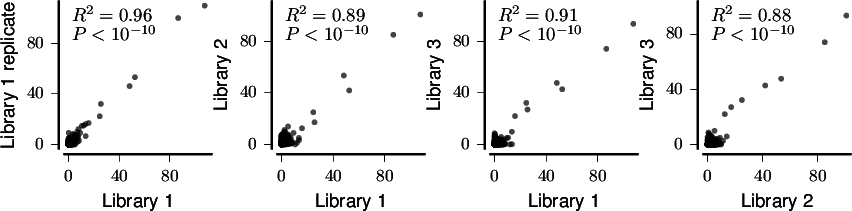

In [12]:
L1_tech_reps = ['{0}/L1_H17L19_c3_r1_vs_L1_mock_r1_sitediffsel.txt'.format(dirs['diffsel']),
                '{0}/L1_H17L19_c3_r2_vs_L1_mock_r2_sitediffsel.txt'.format(dirs['diffsel'])]
bio_reps = ['{0}/L1_H17L19_c3_r1_vs_L1_mock_r1_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L2_H17L19_c3_vs_L2_mock_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L3_H17L19_c3_vs_L3_mock_sitediffsel.txt'.format(dirs['diffsel'])]

plots = []

outfile = '{0}/Corr_H17L19_techreps'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L1_tech_reps[0], L1_tech_reps[1], outfile, 'Library 1', 'Library 1 replicate')

outfile = '{0}/Corr_H17L19_biorep12'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(bio_reps[0], bio_reps[1], outfile, 'Library 1', 'Library 2')

outfile = '{0}/Corr_H17L19_biorep13'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(bio_reps[0], bio_reps[2], outfile, 'Library 1', 'Library 3')

outfile = '{0}/Corr_H17L19_biorep23'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(bio_reps[1], bio_reps[2], outfile, 'Library 2', 'Library 3')

ShowPDF([f + '.pdf' for f in plots])

technical and biological replicate correlations for mutation differential selection for the same comparisons:

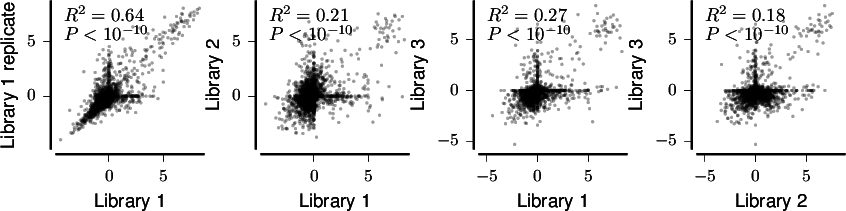

In [13]:
L1_tech_reps = ['{0}/L1_H17L19_c3_r1_vs_L1_mock_r1_mutdiffsel.txt'.format(dirs['diffsel']),
                '{0}/L1_H17L19_c3_r2_vs_L1_mock_r2_mutdiffsel.txt'.format(dirs['diffsel'])]
bio_reps = ['{0}/L1_H17L19_c3_r1_vs_L1_mock_r1_mutdiffsel.txt'.format(dirs['diffsel']),
           '{0}/L2_H17L19_c3_vs_L2_mock_mutdiffsel.txt'.format(dirs['diffsel']),
           '{0}/L3_H17L19_c3_vs_L3_mock_mutdiffsel.txt'.format(dirs['diffsel'])]

plots = []
markersize = 3.5
alpha = 0.2
corr_on_plot = True

outfile = '{0}/Corr_H17L19_techreps_mutdiffsel'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L1_tech_reps[0], L1_tech_reps[1], outfile, 'Library 1', 'Library 1 replicate', markersize = markersize, alpha = alpha, corr_on_plot=corr_on_plot)

outfile = '{0}/Corr_H17L19_biorep12_mutdiffsel'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(bio_reps[0], bio_reps[1], outfile, 'Library 1', 'Library 2', markersize = markersize, alpha = alpha, corr_on_plot=corr_on_plot)

outfile = '{0}/Corr_H17L19_biorep13_mutdiffsel'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(bio_reps[0], bio_reps[2], outfile, 'Library 1', 'Library 3', markersize = markersize, alpha = alpha, corr_on_plot=corr_on_plot)

outfile = '{0}/Corr_H17L19_biorep23_mutdiffsel'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(bio_reps[1], bio_reps[2], outfile, 'Library 2', 'Library 3', markersize = markersize, alpha = alpha, corr_on_plot=corr_on_plot)

ShowPDF([f + '.pdf' for f in plots])

Correlations between replicates for H17-L10:

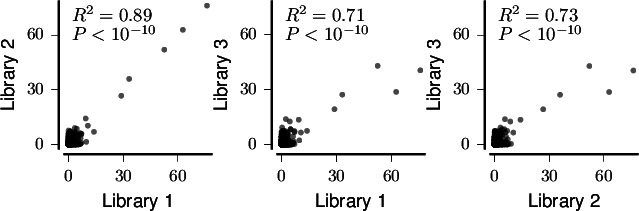

In [14]:
L10_reps = ['{0}/L1_H17L10_vs_L1_mock_r1_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L2_H17L10_vs_L2_mock_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L3_H17L10_vs_L3_mock_sitediffsel.txt'.format(dirs['diffsel'])]

plots = []

outfile = '{0}/Corr_H17L10_biorep12'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L10_reps[0], L10_reps[1], outfile, 'Library 1', 'Library 2')

outfile = '{0}/Corr_H17L10_biorep13'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L10_reps[0], L10_reps[2], outfile, 'Library 1', 'Library 3')

outfile = '{0}/Corr_H17L10_biorep23'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L10_reps[1], L10_reps[2], outfile, 'Library 2', 'Library 3')

ShowPDF([f + '.pdf' for f in plots])

Correlations between replicates for H17-L7:

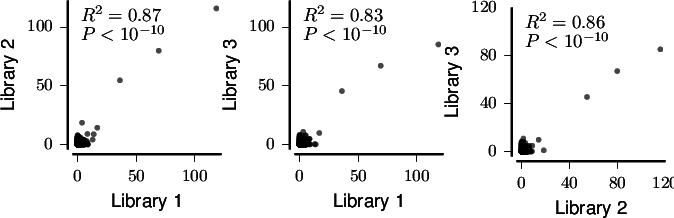

In [15]:
L7_reps = ['{0}/L1_H17L7_vs_L1_mock_r1_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L2_H17L7_vs_L2_mock_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L3_H17L7_vs_L3_mock_sitediffsel.txt'.format(dirs['diffsel'])]

plots = []

outfile = '{0}/Corr_H17L7_biorep12'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L7_reps[0], L7_reps[1], outfile, 'Library 1', 'Library 2')

outfile = '{0}/Corr_H17L7_biorep13'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L7_reps[0], L7_reps[2], outfile, 'Library 1', 'Library 3')

outfile = '{0}/Corr_H17L7_biorep23'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(L7_reps[1], L7_reps[2], outfile, 'Library 2', 'Library 3')

ShowPDF([f + '.pdf' for f in plots])

Correlations between replicates for H18-S415

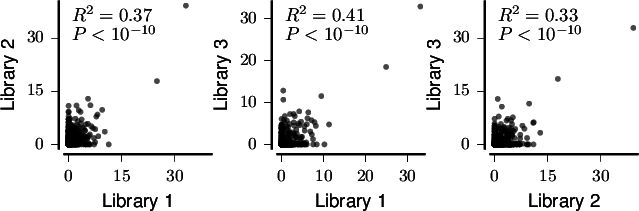

In [16]:
H18S415_reps = ['{0}/L1_H18S415_vs_L1_mock_r1_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L2_H18S415_vs_L2_mock_sitediffsel.txt'.format(dirs['diffsel']),
           '{0}/L3_H18S415_vs_L3_mock_sitediffsel.txt'.format(dirs['diffsel'])]

plots = []

outfile = '{0}/Corr_H18S415_biorep12'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(H18S415_reps[0], H18S415_reps[1], outfile, 'Library 1', 'Library 2')

outfile = '{0}/Corr_H18S415_biorep13'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(H18S415_reps[0], H18S415_reps[2], outfile, 'Library 1', 'Library 3')

outfile = '{0}/Corr_H18S415_biorep23'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(H18S415_reps[1], H18S415_reps[2], outfile, 'Library 2', 'Library 3')

ShowPDF([f + '.pdf' for f in plots])

## average differential selection across replicate experiments with independent mutant virus libraries

In [17]:
def AverageDiffsel(infiles, outmutdiffselfile, outsitediffselfile):
    subprocess.check_call(['dms_merge',
                           outmutdiffselfile,
                           'average'] + infiles + 
                          ['--sitediffselfile', outsitediffselfile
                          ])

In [18]:
# for H17-L19, average the technical replicates of library 1, then average across biological replicates. Do this for each concentration of H17-L19:
for conc in [1,2,3]:
    # average technical replicates of library 1 at each concentration
    files = ['{0}/L1_H17L19_c{1}_r1_vs_L1_mock_r1_mutdiffsel.txt'.format(dirs['diffsel'], conc),
             '{0}/L1_H17L19_c{1}_r2_vs_L1_mock_r2_mutdiffsel.txt'.format(dirs['diffsel'], conc)]
    L1_meanmutfile = '{0}/L1_avg_H17L19_c{1}_mutdiffsel.txt'.format(dirs['diffsel'], conc)
    L1_meansitefile = L1_meanmutfile.replace('mutdiffsel.txt','sitediffsel.txt')
    AverageDiffsel(files, L1_meanmutfile, L1_meansitefile)
    
    # average biological replicates, using the average of library 1 technical replicates + library 2 + library 3
    files = ['{0}/L2_H17L19_c{1}_vs_L2_mock_mutdiffsel.txt'.format(dirs['diffsel'], conc),
             '{0}/L3_H17L19_c{1}_vs_L3_mock_mutdiffsel.txt'.format(dirs['diffsel'], conc),
             L1_meanmutfile]

    avg_meanmutfile = '{0}/biorep_avg_H17L19_c{1}_mutdiffsel.txt'.format(dirs['diffsel'], conc)
    avg_meansitefile = avg_meanmutfile.replace('mutdiffsel.txt','sitediffsel.txt')
    AverageDiffsel(files, avg_meanmutfile, avg_meansitefile)

In [19]:
# for H17-L10, H17-L7 and H18-S415, average across the three biological replicates:
for mab in ['H17L10', 'H17L7', 'H18S415']:
    files = ['{0}/L{1}_{2}_vs_L{1}_mock_mutdiffsel.txt'.format(dirs['diffsel'], lib, mab) for lib in [2,3]] + \
            ['{0}/L1_{1}_vs_L1_mock_r1_mutdiffsel.txt'.format(dirs['diffsel'], mab)]
    meanmutfile = '{0}/biorep_avg_{1}_mutdiffsel.txt'.format(dirs['diffsel'], mab)
    meansitefile = meanmutfile.replace('mutdiffsel.txt','sitediffsel.txt')
    AverageDiffsel(files, meanmutfile, meansitefile)

## plot correlations between concentrations of H17-L19

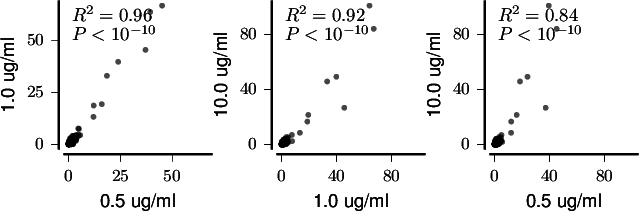

In [20]:
concentration_diffsels = ['{0}/biorep_avg_H17L19_c1_sitediffsel.txt'.format(dirs['diffsel']),
                          '{0}/biorep_avg_H17L19_c2_sitediffsel.txt'.format(dirs['diffsel']),
                          '{0}/biorep_avg_H17L19_c3_sitediffsel.txt'.format(dirs['diffsel'])]
plots = []

markersize = 6
corr_on_plot=True

outfile = '{0}/Corr_H17L19_c1c2'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(concentration_diffsels[0], concentration_diffsels[1], outfile, '0.5 ug/ml', '1.0 ug/ml', markersize = markersize, corr_on_plot=corr_on_plot)

outfile = '{0}/Corr_H17L19_c2c3'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(concentration_diffsels[1], concentration_diffsels[2], outfile, '1.0 ug/ml', '10.0 ug/ml', markersize = markersize, corr_on_plot=corr_on_plot)

outfile = '{0}/Corr_H17L19_c1c3'.format(dirs['plots'])
plots.append(outfile)
PlotCorrelations(concentration_diffsels[0], concentration_diffsels[2], outfile, '0.5 ug/ml', '10.0 ug/ml', markersize = markersize, corr_on_plot=corr_on_plot)


ShowPDF([f + '.pdf' for f in plots])

## plot differential selection across all sites in HA

In [21]:
def PlotPosDiffselBySiteSubplots(sitediffsel_files, sites, numcols, numrows, 
                                outfile=False, ylims=False, xlims=False,
                                figsize_horizontal = 12, figsize_vertical = 8,
                                bar_width = 1, custom_xticks=None):
    '''
    Plot positive differential selection for a given set of sites for several samples arranged in subplots.
    provide *sitediffsel.txt to be plotted left-to-right, top-to-bottom.
    numcols * numrows = len(codon_counts_files)
    '''
    
    # check inputs
    assert len(sitediffsel_files) == numcols*numrows
    
    fig, axes = plt.subplots(nrows=numrows, ncols=numcols, 
                             sharex='col', sharey='row', figsize=(figsize_horizontal,figsize_vertical))
    
    for i,ax in enumerate(axes.flatten()):
                
        # get the data:
        diffsel = pd.read_csv(sitediffsel_files[i])

        # extract the positive diffsel values for each site in the list of *sites*:
        pos_diffsels = [ float(diffsel.loc[diffsel['site'] == r]['positive_diffsel'])  for r in sites]

        ax.bar(sites, pos_diffsels, bar_width, color = 'k', alpha = 1, linewidth=0.1, align='center')

        if ylims:
            ax.set_ylim(bottom=ylims[0], top=ylims[1])
        else:
            pass
        if xlims:
            ax.set_xlim(bottom=xlims[0], top=xlims[1])
        else:
            ax.set_xlim(left=min(sites), right=max(sites))
    
    # clean up axes
    spineOffset = {'left': 2, 'bottom': 2}
    for ax in axes.reshape(-1):
        [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ] 
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', direction='out')
        ax.xaxis.set(ticks_position = 'bottom',  major_locator = MaxNLocator(len(sites), prune=None))
        ax.yaxis.set(ticks_position = 'left', major_locator = MaxNLocator(4, prune=None))
        
    # remove tick labels for all:
    for ax in axes.reshape(-1):
        for xlabel_i in ax.get_xticklabels():
            xlabel_i.set_visible(False)
        for ylabel_i in ax.get_yticklabels():
            ylabel_i.set_visible(False)
    
    # add tick labels to left and bottom:
    if numcols == 1:
        for i, xlabel_i in enumerate(axes[-1].get_xticklabels()):
            xlabel_i.set_visible(True)
            plt.setp(xlabel_i, rotation=0, fontsize=11)
    else:
        for ax in axes[-1]:
            for i, xlabel_i in enumerate(ax.get_xticklabels()):
                xlabel_i.set_visible(True)
                plt.setp(xlabel_i, rotation=0, fontsize=11)

    if numcols == 1:
        for ax in axes:
            for ylabel_i in ax.get_yticklabels():
                ylabel_i.set_visible(True)
    else:
        for ax in axes[:,0]:
            for ylabel_i in ax.get_yticklabels():
                ylabel_i.set_visible(True)
                
    # override with custom xticks and labels if provided
    if custom_xticks is not None:
        plt.xticks(custom_xticks, custom_xticks)

    filepath = '{0}/test_diffselbarplots.pdf'.format(dirs['plots'])
    if outfile:
        filepath = outfile
    plt.savefig(filepath)
    plt.close()

plots for technical and biological replicates of H17-L19 at concentration 3; for figure 2.

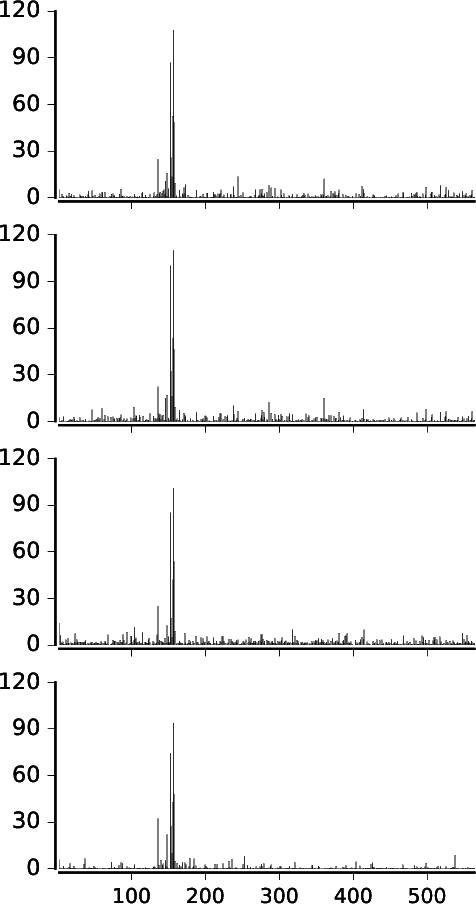

In [22]:
outfile = '{0}/PosDiffselbysite_H17L19_c3_replicates.pdf'.format(dirs['plots'])
numcols = 1
numrows = 4

# left-to-right, top-to-bottom order for subplots
sitediffsel_files = ['{0}/L1_H17L19_c3_r1_vs_L1_mock_r1_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/L1_H17L19_c3_r2_vs_L1_mock_r2_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/L2_H17L19_c3_vs_L2_mock_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/L3_H17L19_c3_vs_L3_mock_sitediffsel.txt'.format(dirs['diffsel']),]

sites = range(2, 565) #
custom_xticks = [100,200,300,400,500]

PlotPosDiffselBySiteSubplots(sitediffsel_files, sites, numcols, numrows, outfile=outfile, 
                            ylims=(0,120), figsize_horizontal = 4, figsize_vertical = 8,
                           bar_width=1, custom_xticks=custom_xticks)

ShowPDF(outfile, width=300)

plots for dose-response of H17-L19:

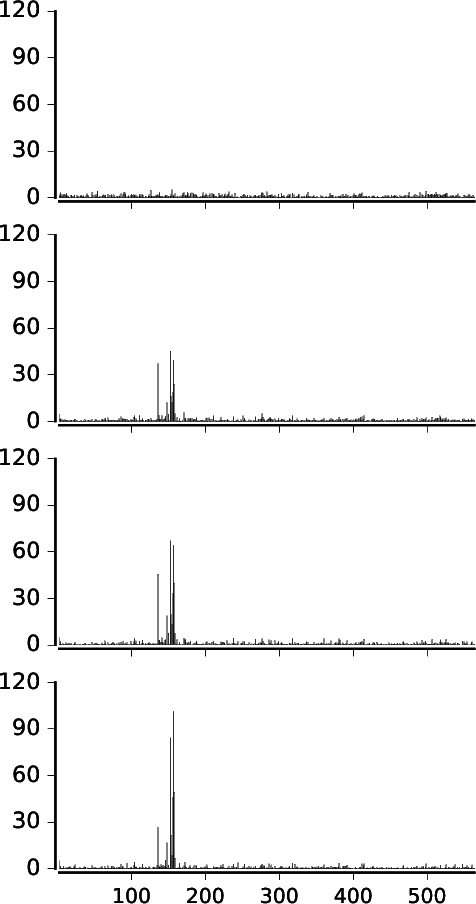

In [23]:
outfile = '{0}/PosDiffselbysite_H17L19doseresponse.pdf'.format(dirs['plots'])
numcols = 1
numrows = 4

# left-to-right, top-to-bottom order for subplots
sitediffsel_files = ['{0}/L1_mockr1_vs_mockr2_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H17L19_c1_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H17L19_c2_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H17L19_c3_sitediffsel.txt'.format(dirs['diffsel']),]

sites = range(2, 565) #
custom_xticks = [100,200,300,400,500]

PlotPosDiffselBySiteSubplots(sitediffsel_files, sites, numcols, numrows, outfile=outfile, 
                            ylims=(0,120), figsize_horizontal = 4, figsize_vertical = 8,
                           bar_width=1, custom_xticks=custom_xticks)

ShowPDF(outfile, width=300)

plots for all mAbs:

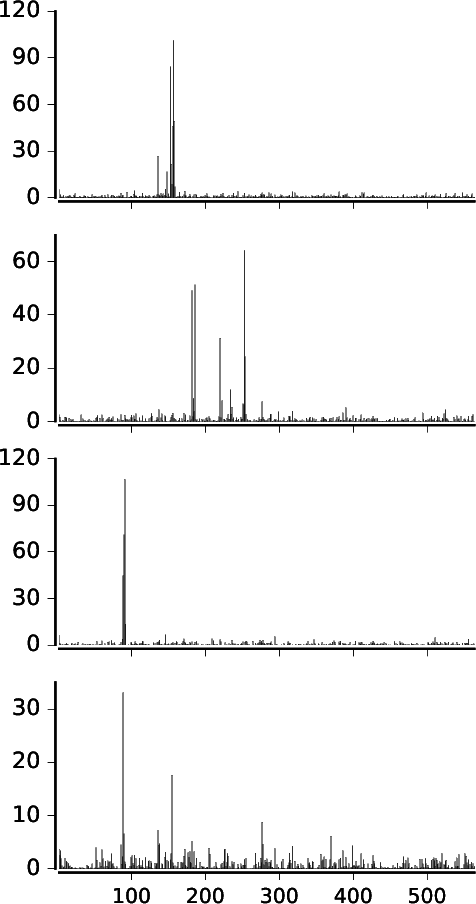

In [24]:
# four mAbs:
outfile = '{0}/PosDiffselbysite_allmabsBiorepAvg.pdf'.format(dirs['plots'])
numcols = 1
numrows = 4

# left-to-right, top-to-bottom order for subplots
sitediffsel_files = ['{0}/biorep_avg_H17L19_c3_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H17L10_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H17L7_sitediffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H18S415_sitediffsel.txt'.format(dirs['diffsel']),]

sites = range(2, 565) #
custom_xticks = [100,200,300,400,500]

PlotPosDiffselBySiteSubplots(sitediffsel_files, sites, numcols, numrows, outfile=outfile, 
                            figsize_horizontal = 4, figsize_vertical = 8,
                            bar_width=1, custom_xticks=custom_xticks)

ShowPDF(outfile, width=300)

## make logoplots of differential selection


In [25]:
def DiffselLogoplots(infiles, nperline='80', numberevery='3', restrictdiffsel='positive', 
                    colormap='jet', suffix=None):
    for infile in infiles:
        if suffix:
            outfile = infile.replace('.txt','{0}_logoplot.pdf'.format(suffix))
        else:
            outfile = infile.replace('.txt','_logoplot.pdf')
        subprocess.check_call(['dms_logoplot', infile, outfile,
                               '--nperline', nperline, '--numberevery', numberevery, 
                               '--restrictdiffsel', restrictdiffsel, '--colormap', colormap,
                               '--mapmetric', 'functionalgroup',
                               '--nosepline',
                               '--diffselheight'] + infiles)

In [26]:
# all four experimental replicates for H17-L19 at concentration 3 (two technical replicates of library 1, and library 2 and 3) equally scalled (for Figure 2):
replicate_diffsel_files = ['{0}/L1_H17L19_c3_r1_vs_L1_mock_r1_mutdiffsel.txt'.format(dirs['diffsel']),
                           '{0}/L1_H17L19_c3_r2_vs_L1_mock_r2_mutdiffsel.txt'.format(dirs['diffsel']),
                           '{0}/L2_H17L19_c3_vs_L2_mock_mutdiffsel.txt'.format(dirs['diffsel']),
                           '{0}/L3_H17L19_c3_vs_L3_mock_mutdiffsel.txt'.format(dirs['diffsel']),
                          ]
DiffselLogoplots(replicate_diffsel_files, suffix='four_replicates_scaled')

In [27]:
# mock_vs_mock and the three concentrations of H17-L19 (averaged), all equally scaled, for dose-response figure 3:
dose_response_diffsel_files = ['{0}/L1_mockr1_vs_mockr2_mutdiffsel.txt'.format(dirs['diffsel']),
                    '{0}/biorep_avg_H17L19_c1_mutdiffsel.txt'.format(dirs['diffsel']),
                    '{0}/biorep_avg_H17L19_c2_mutdiffsel.txt'.format(dirs['diffsel']),
                    '{0}/biorep_avg_H17L19_c3_mutdiffsel.txt'.format(dirs['diffsel'])]

DiffselLogoplots(dose_response_diffsel_files)

In [28]:
# biological replicate averages for all four mAbs, auto-scaling for each mab (Figure 4 main figure):
mab_diffsel_files = ['{0}/biorep_avg_H17L19_c3_mutdiffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H17L7_mutdiffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H17L10_mutdiffsel.txt'.format(dirs['diffsel']),
                     '{0}/biorep_avg_H18S415_mutdiffsel.txt'.format(dirs['diffsel']),
                     ]

for f in mab_diffsel_files:
    DiffselLogoplots([f], suffix='autoscale')
    
# individual replicates for each mAb besides H17L19, each trio equally scalled within each mAb:
for mab in ['H17L7', 'H17L10', 'H18S415']:
    mab_replicates = ['{0}/L1_{1}_vs_L1_mock_r1_mutdiffsel.txt'.format(dirs['diffsel'], mab),
                      '{0}/L2_{1}_vs_L2_mock_mutdiffsel.txt'.format(dirs['diffsel'], mab),
                      '{0}/L3_{1}_vs_L3_mock_mutdiffsel.txt'.format(dirs['diffsel'], mab),
                      ]
    DiffselLogoplots(mab_replicates, suffix='scaled_within_{0}_replicates'.format(mab))

## make pymol scripts to project max(mutdiffsel) to structure

In [29]:
def MapDiffselColorToSite(diffselfile, scriptfile, script_type='pymol', 
                          map_type='abs_diffsel', colors = ['#ffff99', '#990000'], sitecolorfile=None,
                          script_preamble=False, restrict_to_chain=False, prefsfile=None):
    '''Produces a colormapping based on differential selection and writes a script for `pymol` or `chimera`
    to color a structure by this colormapping.
    
    Uses the data in *diffselfile*, which can be either a mutdiffsel or a sitediffsel file, 
    depending on the specified *map_type*. 
    
    Writes a python script to *scriptfile* for the molecular visualization program specified 
    in *script_type* (either `pymol` or `chimera`).
    
    *colors* is a list of two colors defined by hex or r,g,b codes.
    
    How the mapping from differential selection to color is determined is specified by the 
    following choices for *map_type*:
    
        * `abs_diffsel`: plot total absolute differential selection at each site. 
        Total absolute differential selection will be converted to color by interpolating between 
        the two *colors*, which will be used to show the minimum and maximum values, respectively.
        Requries *diffselfile* to be a '*sitediffsel.txt' file.
        
        * `positive_diffsel`: plot the total positive differential selection at each site. 
        Absolute positive differential selection will be converted to color by interpolating between 
        the two *colors*, which will be used to show the minimum and maximum values, respectively.
        Requries *diffselfile* to be a '*sitediffsel.txt' file.
        
        * `negative_diffsel`: plot the total negative differential selection at each site. 
        Absolute negative differential selection will be converted to color by interpolating between 
        the two *colors*, which will be used to show the (absolute) minimum and maximum values, respectively.
        Requries *diffselfile* to be a '*sitediffsel.txt' file.
        
        * `max_pos_mutdiffsel`: plot the maximum positive mutdiffsel at each site (the value for the most 
        strongly enriched mutation at each site).
        Requries *diffselfile* to be a '*mutdiffsel.txt' file.
        
        * `positive_diffsel_by_Neff`: plot the total positive differential selection at each site,
        divided by Neff, the effective number of amino-acid mutations (exp(h) where h is the Shannon entropy of
        the amino-acid preference distribution at the site). This normalizes the total amount of
        differential selection at a site by the mutational tolerance at that site. If using this option, a
        path to a valid preferences file *prefsfile* must be provided as an additional keyword argument.
        
    
    If you want to restrict the recoloring to a single chain, specify the name of the chain to color to 
    *restrict_to_chain*. This currently only works for pymol scripts, not chimera scripts.
        
    Optionally, provide a path for a *sitecolorfile* to which the (site, hexcolor, rgbcolor) mappings are
    written.
    
    Optionally, if a *script_preamble* is provided, it is written to the top of the script before the 
    commands for colormapping. This may be a useful place to add other pymol or chimera commands to load 
    the pdb file, orient the view, etc.
    '''

    # read in the data from the diffselfile:
    df = pd.read_csv(diffselfile)
    df = df.dropna()
    column_names = list(df)
    if column_names == ['site', 'wt', 'mut', 'diffsel']:
        filetype = 'mutdiffsel'
    elif column_names == ['site', 'abs_diffsel', 'positive_diffsel', 'negative_diffsel']:
        filetype = 'sitediffsel'
    else:
        raise ValueError('diffsel file does not have appropriate set of column identifiers')
    
    # establish the color spectrum in hex and rgb.
    n_subdivisions = 500 # the color spectrum will be divided into this many discrete colors
    color1 = Color(colors[0])
    color2 = Color(colors[1])
    hex_spectrum = [c.hex for c in color1.range_to(color2, n_subdivisions)]
    hex_spectrum_dict = dict([(i, hex_spectrum[i]) for i in range(len(hex_spectrum))]) 
    rgb_spectrum = [c.rgb for c in color1.range_to(color2, n_subdivisions)]
    rgb_spectrum_dict = dict([(i, rgb_spectrum[i]) for i in range(len(rgb_spectrum))])
    
    # generate the site ==> colorindex mapping based on *map_type*:
    if map_type == 'abs_diffsel':
        assert filetype == 'sitediffsel'
        min_diff = df.min()['abs_diffsel']  
        max_diff = df.max()['abs_diffsel']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        df['colorindex'] =  (df.abs_diffsel - min_diff)/range_diff*(n_subdivisions-1)
        
    elif map_type == 'negative_diffsel':
        assert filetype == 'sitediffsel'
        abs_neg_col = abs(df['negative_diffsel'])
        df = df.assign(abs_neg=abs_neg_col)
        min_diff = df.min()['abs_neg']  
        max_diff = df.max()['abs_neg']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        df['colorindex'] =  (df.abs_neg - min_diff)/range_diff*(n_subdivisions-1)
            
    elif map_type == 'positive_diffsel':
        assert filetype == 'sitediffsel'
        min_diff = df.min()['positive_diffsel']  
        max_diff = df.max()['positive_diffsel']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        df['colorindex'] =  (df.positive_diffsel - min_diff)/range_diff*(n_subdivisions-1)
    
    elif map_type == 'positive_diffsel_by_Neff':
        assert filetype == 'sitediffsel'
        # get entropies, make Neff dict, and normalize positive_diffsel values by Neff:
        (sites, wts, pi_means, pi_95credint, h) = dms_tools.file_io.ReadPreferences(prefsfile)
        neff_dict = {} # keyed by int(site) so that it can be mapped to the diffsel dataframe. 
        # this will be problematic with non-integer site strings... 
        # maybe best fix will be to cast the site column of the dataframe as string,
        # and see if the map function will work with a dictionary of strings as sites.
        for site, entropy in h.iteritems():
            neff_dict[int(site)] = 2.**entropy
        df['neff'] = df['site'].map(neff_dict)
        df['positive_diffsel_by_Neff'] = df['positive_diffsel']/df['neff']
        
        min_diff = df.min()['positive_diffsel_by_Neff']  
        max_diff = df.max()['positive_diffsel_by_Neff']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        df['colorindex'] =  (df.positive_diffsel_by_Neff - min_diff)/range_diff*(n_subdivisions-1)
        
        # since there are no preferences for site 1, the colorindex is currently NaN when using Neff.
        # fill to 0.
        df['colorindex'] = df['colorindex'].fillna(0)
    
    elif map_type == 'max_pos_mutdiffsel':
        assert filetype == 'mutdiffsel'
        # sort mutdiffsel file by diffsel in case it wasn't already:
        df.sort_values('diffsel', ascending=False, inplace=True)
        # a new dataframe to only store the max mutdiffsel from each site
        newdf = pd.DataFrame(columns=['site', 'wt', 'mut', 'diffsel']) 
        for row in df.itertuples():
            if not any(newdf['site'].astype(int) == int(row[1])):
                newdf = newdf.append(pd.DataFrame([row[1:]], columns = ['site', 'wt', 'mut', 'diffsel']))
        newdf['site'] = newdf['site'].apply(int)
        # replace negative values with zero at sites where there was no positive selection:
        newdf = newdf.clip(lower=0)
        min_diff = newdf.min()['diffsel']  
        max_diff = newdf.max()['diffsel']  # the min and max will be mapped to color1 and color2, respectively
        range_diff = max_diff - min_diff
        newdf['colorindex'] =  (newdf.diffsel - min_diff)/range_diff*(n_subdivisions-1)
        df = newdf        

    else:
        raise ValueError("%s is not a recognized map_type." % map_type)
        
    # add a column for colors for each site    
    df['colorindex'] = df['colorindex'].astype(int) # round to nearest index
    df['hex'] = df['colorindex'].map(hex_spectrum_dict)
    df['rgb'] = df['colorindex'].map(rgb_spectrum_dict)        
    site_color_mapping = pd.concat([df['site'], df['hex'], df['rgb']], axis=1)
    
    if sitecolorfile:
        site_color_mapping.to_csv(sitecolorfile, index=False)
    
    # write out the script to *scriptfile*:
    f = open(scriptfile, 'w')
    
    if script_preamble:
        for line in script_preamble:
            f.write(line)
    
    if script_type == 'chimera':
        f.write("from chimera import runCommand\n")
        for i in range(len(df.index)):
            f.write("runCommand(color %s :%s)" % (site_color_mapping.iloc[i]['hex'], site_color_mapping.iloc[i]['site']) )
    elif script_type == 'pymol':
        for i in range(len(df.index)):
            rgblist = [min(1, c) for c in site_color_mapping.iloc[i]['rgb']]
            f.write("cmd.set_color(\'color%s\', \'%s\')\n" % (site_color_mapping.iloc[i]['site'], rgblist))
            if restrict_to_chain:
                f.write("cmd.color(\'color%s\', \'chain %s and resi %s\')\n" % (site_color_mapping.iloc[i]['site'], restrict_to_chain, site_color_mapping.iloc[i]['site']))
            else:
                f.write("cmd.color(\'color%s\', \'resi %s\')\n" % (site_color_mapping.iloc[i]['site'], site_color_mapping.iloc[i]['site']))
    else:
        raise ValueError("script_type must be chimera or pymol.")
    f.close()

In [30]:
colors = ('#fafafa', '#ff0000')

mutdiffselfiles = ['{0}/biorep_avg_H17L19_c3_mutdiffsel.txt'.format(dirs['diffsel']),
                   '{0}/biorep_avg_H17L10_mutdiffsel.txt'.format(dirs['diffsel']),
                   '{0}/biorep_avg_H17L7_mutdiffsel.txt'.format(dirs['diffsel']),
                   '{0}/biorep_avg_H18S415_mutdiffsel.txt'.format(dirs['diffsel']),
                  ]
mutmap_types = ['max_pos_mutdiffsel']

base_script_preample = [
    "cmd.set('bg_rgb','[1,1,1]')\n",
    "cmd.set('specular', '0')\n",
    "cmd.set('light_count','0')\n",
    "cmd.set('antialias','2')\n"]

view = (\
    -0.760245264,   -0.039225433,    0.648637414,\
    -0.649792910,    0.052100927,   -0.758461475,\
    -0.004043628,   -0.997895658,   -0.065079078,\
     0.001003772,   -0.004310774, -404.710021973,\
    77.289749146,   -5.298280716,   19.263229370,\
   319.299011230,  490.685546875,  -20.000000000 )

set_view = "cmd.set_view('%s')\n" % ', '.join([str(v) for v in view])
base_script_preample.append(set_view)

for f in mutdiffselfiles:
    for map_type in mutmap_types:
        outfile = f.replace('.txt','_%s_colormapping.py' % map_type)
        MapDiffselColorToSite(f, outfile, map_type = map_type, colors=colors, script_preamble=base_script_preample)

In [ ]:
# for making figure zooming in on each epitope:

L19_zoom_view = (\
    -0.976966500,   -0.048147742,    0.208509833,\
    -0.212888569,    0.120258600,   -0.969767988,\
     0.021608414,   -0.991602182,   -0.127704829,\
    -0.014455989,   -0.001244724, -211.759735107,\
    60.558479309,   -2.605110168,  -15.578004837,\
   127.427650452,  298.814392090,  -20.000000000 )

L10_zoom_view = (\
    -0.829147160,   -0.013435517,    0.559087157,\
    -0.558676898,   -0.024620410,   -0.829147637,\
     0.024898469,   -0.999630868,    0.012910990,\
    -0.014740715,    0.000468306, -160.154312134,\
    77.069519043,   -3.746402740,  -21.436498642,\
    75.833206177,  247.219696045,  -20.000000000 )

Cb_zoom_view = (\
    -0.104112580,   -0.146713927,    0.983813584,\
    -0.993929207,   -0.022947490,   -0.108612485,\
     0.038506679,   -0.988943219,   -0.143396497,\
    -0.001266338,   -0.003537253, -220.251998901,\
    77.218444824,   -3.926383495,   -7.785912991,\
   136.186401367,  307.573211670,  -20.000000000 )